# Blind Extraction of Equitable Partitions (Experiments)

This notebook guides the process of creating the figures presented in Figure 2 of the paper. 


In [1]:
import numpy as np
import networkx as nx
import blindEP_utils as main
import matplotlib.pyplot as plt

The second cell defines the KMeans cost function $F$, that is used for node-level evaluation of the performance of the algorithms.

In [2]:
def F_function(U, classes):
    c, counts = np.unique(classes, return_counts=True)
    H = np.array([[1/np.sqrt(counts[j]) if classes[i] == c[j] else 0 for i in range(len(classes))] for j in range(len(c))])
    return np.linalg.norm(U - H.transpose() @ H @ U, ord="fro")**2

The third and fifth cell define the experimental setups. Firstly, $\alpha = 0.7$ is fixed. For $20$ evenly-spaced values in $s \in [10,400]$ for the number of samples and $1000$ trials, we sample the symmetric quotient adjacency matrix $A_\pi \in \{0,...,4\}^{6 \times 6}$. We then use this to create the actual graph by employing a colored configuration model. This way, there exists an EP $AH = H A_\pi$ by design and it is very probable to be the coarsest. 

We then use this adajcency matrix and sample $Y \in R^{n \times s}$ and compute the convariance matrix $\Sigma = \frac{1}{s}\sum_{i=1}^s y_i y_i^T$. $\Sigma$ is then given to the BlindWL algorithm as an approximate oracle and to Kmeans for spectral clustering. 

In [3]:
#initialize arrays to store results
sum_acc_bwl_1, sum_acc_ep_1, sum_acc_bwl_x_1, sum_nl_f_bwl_1, sum_nl_f_ep_1 = [],[],[],[],[]
#hyperparameters of the experiments
alpha = 0.7
num_trials = 1000
num_classes = 6
size_classes = 50
for num_samples in range(10,400, 20):
    #intialize array to store results for a single parameter value
    acc_bwl, acc_ep, acc_bwl_x, nl_f_bwl, nl_f_ep = 0,0,0,0,0
    for ex in range(num_trials):
        print(num_samples, ex, end="\r")
        X, Y = [],[]
        #sample random quotient adacency matrix
        A_pi = np.random.randint(0,5, size=(num_classes, num_classes))
        #make symmetrical
        for i in range(len(A_pi)):
            for j in range(i+1,len(A_pi)):
                A_pi[j,i] = A_pi[i,j]
            
        #sample graph from given quotient adjacency matrix A_pi
        A = main.sample_csEP([size_classes] * num_classes, A_pi.tolist(), multi_graph_okay=False)
        H = np.array([[1 if i == int(j/size_classes) else 0 for j in range(num_classes * size_classes)] for i in range(num_classes)]).transpose()
        H_plus = np.linalg.pinv(H)
        X = np.random.normal(0,1,(H.shape[1],num_samples))
        H_tilde = H @ np.diag([1/np.sqrt(size_classes) for i in range(6)])
        
        #sample Y samples from the defined graph filter
        Y = alpha* (A @  H_tilde @ X) + (1-alpha) * np.random.normal(0,1,(A.shape[1],num_samples))
        Sigma =  (np.mean([np.outer(Y[:,i], Y[:,i]) for i in range(Y.shape[1])], axis=0))

        #get actual structural EVs (used for the computation of F)
        U, _, _ = np.linalg.svd(A_pi)
        U = H_tilde @ U
        
        #EP extraction by BlindWL
        bwl_output = main.blind_WL_from_outputs(Sigma, max_num_components=num_classes, n_init=2, verbose=False, method="gm")
        #acc += 1 only if all nodes are correctly classified
        acc_bwl += main.is_equivalent(main.weisfeiler_lehman(nx.from_numpy_array(A))[0], bwl_output)
        #compute mean of trials of the KMeans cost function
        nl_f_bwl += F_function(U, bwl_output)

        #EP extraction by spectral clustering
        ep_output =  main.EP_from_outputs(Sigma, max_num_components=num_classes, method="kmeans")
        acc_ep += main.is_equivalent(main.weisfeiler_lehman(nx.from_numpy_array(A))[0], ep_output)
        nl_f_ep += F_function(U, ep_output)

    #store for plotting
    sum_acc_bwl_1.append(acc_bwl/num_trials)
    sum_nl_f_bwl_1.append(nl_f_bwl/num_trials)
    sum_acc_ep_1.append(acc_ep/num_trials)
    sum_nl_f_ep_1.append(nl_f_ep/num_trials)


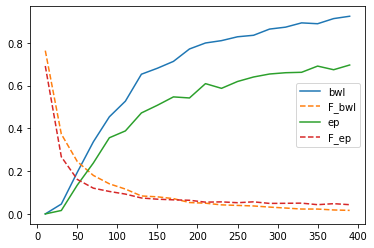

[0.0, 0.046, 0.195, 0.337, 0.454, 0.527, 0.653, 0.681, 0.713, 0.771, 0.799, 0.81, 0.828, 0.835, 0.864, 0.873, 0.893, 0.889, 0.913, 0.924] [3.053053341511305, 1.4935854094261627, 0.9783205297066844, 0.7198075037805555, 0.5626227243109675, 0.4646294634186944, 0.33568608841221204, 0.3193156359127719, 0.2864604072600725, 0.2128143433729286, 0.2004293674650258, 0.16917894102824887, 0.15899786851635211, 0.14865941937464042, 0.12765822038308455, 0.10998600133354697, 0.09117051883064163, 0.09082271478976095, 0.07382297783243986, 0.06607050978671174] [0.0, 0.016, 0.135, 0.238, 0.356, 0.388, 0.472, 0.508, 0.547, 0.542, 0.609, 0.587, 0.619, 0.64, 0.654, 0.66, 0.662, 0.691, 0.674, 0.696] [2.76578691568157, 1.0680068633894197, 0.6444607534581157, 0.4815754508139871, 0.4199725744205206, 0.3707576389723849, 0.29797693959004357, 0.27525495700123587, 0.26324496721076324, 0.2551227988717765, 0.2201923586698194, 0.22507968102774628, 0.20965793557489718, 0.22587543886245456, 0.19636672707636882, 0.1984765

In [4]:
plt.plot(range(10,400, 20), sum_acc_bwl_1, label="bwl")
plt.plot(range(10,400, 20), 1/4 * np.array(sum_nl_f_bwl_1), label="F_bwl", linestyle='dashed')
plt.plot(range(10,400, 20), sum_acc_ep_1, label="ep")
plt.plot(range(10,400, 20), 1/4 * np.array(sum_nl_f_ep_1), label="F_ep", linestyle='dashed')
plt.legend()
plt.show()
print(sum_acc_bwl_1,sum_nl_f_bwl_1, sum_acc_ep_1, sum_nl_f_ep_1)

We repeat the experimental setup, instead fixing $s$ and varying $\alpha$. 

In [5]:
sum_acc_bwl_2, sum_acc_ep_2, sum_acc_bwl_x_2, sum_nl_f_bwl_2, sum_nl_f_ep_2 = [],[],[],[],[]
num_samples = 300
num_trials = 1000
num_classes = 6
size_classes = 50
for alpha in np.linspace(0.01,0.99, 21):
#intialize array to store results for a single parameter value
    acc_bwl, acc_ep, acc_bwl_x, nl_f_bwl, nl_f_ep = 0,0,0,0,0
    for ex in range(num_trials):
        print(alpha, ex, end="\r")
        X, Y = [],[]
        #sample random quotient adacency matrix
        A_pi = np.random.randint(0,5, size=(num_classes, num_classes))
        #make symmetrical
        for i in range(len(A_pi)):
            for j in range(i+1,len(A_pi)):
                A_pi[j,i] = A_pi[i,j]
            
        #sample graph from given quotient adjacency matrix A_pi
        A = main.sample_csEP([size_classes] * num_classes, A_pi.tolist(), multi_graph_okay=False)
        H = np.array([[1 if i == int(j/size_classes) else 0 for j in range(num_classes * size_classes)] for i in range(num_classes)]).transpose()
        H_plus = np.linalg.pinv(H)
        X = np.random.normal(0,1,(H.shape[1],num_samples))
        H_tilde = H @ np.diag([1/np.sqrt(size_classes) for i in range(6)])
        
        #sample Y samples from the defined graph filter
        Y = alpha* (A @  H_tilde @ X) + (1-alpha) * np.random.normal(0,1,(A.shape[1],num_samples))
        Sigma =  (np.mean([np.outer(Y[:,i], Y[:,i]) for i in range(Y.shape[1])], axis=0))

        #get actual structural EVs (used for the computation of F)
        U, _, _ = np.linalg.svd(A_pi)
        U = H_tilde @ U
        
        #EP extraction by BlindWL
        bwl_output = main.blind_WL_from_outputs(Sigma, max_num_components=num_classes, n_init=2, verbose=False, method="gm")
        #acc += 1 only if all nodes are correctly classified
        acc_bwl += main.is_equivalent(main.weisfeiler_lehman(nx.from_numpy_array(A))[0], bwl_output)
        #compute mean of trials of the KMeans cost function
        nl_f_bwl += F_function(U, bwl_output)

        #EP extraction by spectral clustering
        ep_output =  main.EP_from_outputs(Sigma, max_num_components=num_classes, method="kmeans")
        acc_ep += main.is_equivalent(main.weisfeiler_lehman(nx.from_numpy_array(A))[0], ep_output)
        nl_f_ep += F_function(U, ep_output)

    #store for plotting
    sum_acc_bwl_2.append(acc_bwl/num_trials)
    sum_nl_f_bwl_2.append(nl_f_bwl/num_trials)
    sum_acc_ep_2.append(acc_ep/num_trials)
    sum_nl_f_ep_2.append(nl_f_ep/num_trials)


In [6]:
plt.plot(np.linspace(0.01,0.99, 21), sum_acc_bwl_2, label="bwl")
plt.plot(np.linspace(0.01,0.99, 21), 1/4 * np.array(sum_nl_f_bwl_2), label="F_bwl", linestyle='dashed')
plt.plot(np.linspace(0.01,0.99, 21), sum_acc_ep_2, label="ep")
plt.plot(np.linspace(0.01,0.99, 21), 1/4 * np.array(sum_nl_f_ep_2), label="F_ep", linestyle='dashed')
plt.legend()
plt.show()
print(sum_acc_bwl_2,sum_nl_f_bwl_2, sum_acc_ep_2, sum_nl_f_ep_2)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.03, 0.145, 0.303, 0.547, 0.732, 0.858, 0.954, 0.979, 0.988, 0.991, 0.997, 0.998] [4.929999580913286, 4.920538563340187, 4.861495906996798, 4.7367230928710935, 4.554857206669696, 4.332778338952345, 3.929589276241541, 3.3754495750491516, 2.6153558927558884, 1.8489471831570388, 1.206955596978713, 0.7559805658384581, 0.43738137130789606, 0.2410743081339263, 0.13208711003278856, 0.044328633607342176, 0.020166755508173415, 0.013812518527806046, 0.0029849999999999994, 0.001, 0.0010000000000000005] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.051, 0.131, 0.273, 0.407, 0.543, 0.653, 0.731, 0.818, 0.872, 0.921, 0.958, 0.987] [4.916143740180565, 4.90986853334404, 4.8904142911036725, 4.8072096364756804, 4.560200631105108, 4.016179566403475, 3.277308183147125, 2.4156785620757213, 1.7409195453802788, 1.249562220713203, 0.8547602628636556, 0.5724903683856468, 0.39267967834701795, 0.2862994352162903, 0.19481633855527586, 0.144355344812185, 0.097884

Finally, both experiments are plotted in the same figure as seen in the paper:

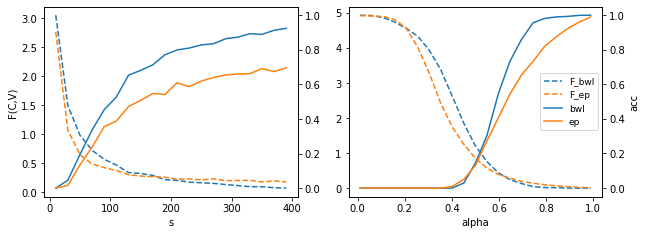

In [7]:
plt.figure(figsize=(10,3.5), frameon=False)
plt.subplot(1,2,1)
plt.xlabel("s")
plt.ylabel("F(C,V)")
ax1 = plt.gca()
ax1.plot(range(10,400, 20), np.array(sum_nl_f_bwl_1), label="F_bwl", linestyle='dashed', color='tab:blue')
ax1.plot(range(10,400, 20), np.array(sum_nl_f_ep_1), label="F_ep", linestyle='dashed', color='tab:orange')


ax2 = ax1.twinx()
ax2.plot(range(10,400, 20), sum_acc_bwl_1, label="bwl", color='tab:blue')
ax2.plot(range(10,400, 20), sum_acc_ep_1, label="ep", color='tab:orange')



plt.ylim([-.05,1.05])
plt.subplot(1,2,2)
plt.xlabel("alpha")

ax1 = plt.gca()
l1, = ax1.plot(np.linspace(0.01,0.99, 21), np.array(sum_nl_f_bwl_2), label="F_bwl", linestyle='dashed', color='tab:blue')
l2, = ax1.plot(np.linspace(0.01,0.99, 21), np.array(sum_nl_f_ep_2), label="F_ep", linestyle='dashed', color='tab:orange')


ax2 = ax1.twinx()
plt.ylabel("acc")
l3, = ax2.plot(np.linspace(0.01,0.99, 21), sum_acc_bwl_2, label="bwl", color='tab:blue')
l4, = ax2.plot(np.linspace(0.01,0.99, 21), sum_acc_ep_2, label="ep", color='tab:orange')
plt.legend([l1,l2,l3,l4], ["F_bwl", "F_ep","bwl", "ep"], loc='right', prop={'size':9})
plt.savefig("combined_view2", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()